In [1]:
import torch
import numpy as np
import os
os.chdir('..')

import torch_converter as tc
import instance_generator as ig
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from util import NumpyDataset, Dataset
from evaluate import evaluate_model, pp_output
import evaluate as ev
from gnn_library.node_selectors import TorchNodeSelector, GreedyNodeSelector

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 2.0.0+cu117
Using device: cuda:2


In [3]:
GNN1, args1 = load('GNN1', device)
GNN2, args2 = load('GNN2', device)

### I. Meta GNN training/evaluation

In [42]:
selector1 = TorchNodeSelector(GNN1)
selector2 = TorchNodeSelector(GNN2)
selector3 = GreedyNodeSelector()

args = {
    'processor':         'GENConv',
    'head':              'meta',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        4,
    'output_dim':        3,
    'dropout':           0.25,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 50; test_num = 10

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = Dataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[selector1, selector2, selector3]
    )
)

test_data = Dataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[selector1, selector2, selector3]
    )
)

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [44]:
args['epochs'] = 100
_, _, META_GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/100 [00:00<?, ?Epochs/s]

0.8808706794053983


Training:   1%|          | 1/100 [00:03<05:37,  3.41s/Epochs]

TEST LOSS: 0.8740912079811096


Training:   2%|▏         | 2/100 [00:05<04:43,  2.89s/Epochs]

0.8521308103040286
0.8224346090817137


Training:   3%|▎         | 3/100 [00:09<04:56,  3.05s/Epochs]

TEST LOSS: 0.82154780626297


Training:   4%|▍         | 4/100 [00:11<04:29,  2.80s/Epochs]

0.7874601055718696
0.7468724908033764


Training:   5%|▌         | 5/100 [00:14<04:40,  2.96s/Epochs]

TEST LOSS: 0.7339855432510376


Training:   6%|▌         | 6/100 [00:17<04:22,  2.79s/Epochs]

0.7154989704521675
0.6844416369772235


Training:   7%|▋         | 7/100 [00:20<04:32,  2.93s/Epochs]

TEST LOSS: 0.6775308847427368


Training:   8%|▊         | 8/100 [00:23<04:18,  2.81s/Epochs]

0.6549320909241172
0.627800650202786


Training:   9%|▉         | 9/100 [00:26<04:26,  2.93s/Epochs]

TEST LOSS: 0.6171528697013855


Training:  10%|█         | 10/100 [00:28<04:09,  2.77s/Epochs]

0.5975265994489906
0.5699025488981176


Training:  11%|█         | 11/100 [00:31<04:14,  2.86s/Epochs]

TEST LOSS: 0.5619569420814514


Training:  12%|█▏        | 12/100 [00:34<03:59,  2.73s/Epochs]

0.5429034358769007
0.5200816534466441


Training:  13%|█▎        | 13/100 [00:37<04:10,  2.88s/Epochs]

TEST LOSS: 0.5158018469810486


Training:  14%|█▍        | 14/100 [00:39<03:54,  2.73s/Epochs]

0.49883973089749195
0.4778906063017142


Training:  15%|█▌        | 15/100 [00:43<04:09,  2.93s/Epochs]

TEST LOSS: 0.4788520932197571


Training:  16%|█▌        | 16/100 [00:45<03:53,  2.79s/Epochs]

0.45694838706752183
0.4423642984808058


Training:  17%|█▋        | 17/100 [00:49<04:09,  3.00s/Epochs]

TEST LOSS: 0.43931883573532104


Training:  18%|█▊        | 18/100 [00:51<03:57,  2.90s/Epochs]

0.4264274406498866
0.41191134641333443


Training:  19%|█▉        | 19/100 [00:55<04:03,  3.01s/Epochs]

TEST LOSS: 0.40458691120147705


Training:  20%|██        | 20/100 [00:57<03:49,  2.86s/Epochs]

0.40094488608007817
0.38691737379283947


Training:  21%|██        | 21/100 [01:00<03:54,  2.97s/Epochs]

TEST LOSS: 0.3799213469028473


Training:  22%|██▏       | 22/100 [01:03<03:43,  2.86s/Epochs]

0.37527792010978067
0.3677008304627366


Training:  23%|██▎       | 23/100 [01:06<03:45,  2.93s/Epochs]

TEST LOSS: 0.3592424690723419


Training:  24%|██▍       | 24/100 [01:08<03:31,  2.79s/Epochs]

0.3582394775111654
0.3541028673868767


Training:  25%|██▌       | 25/100 [01:12<03:43,  2.98s/Epochs]

TEST LOSS: 0.3435453176498413


Training:  26%|██▌       | 26/100 [01:14<03:30,  2.85s/Epochs]

0.34543745325198394
0.34166671610156196


Training:  27%|██▋       | 27/100 [01:18<03:37,  2.98s/Epochs]

TEST LOSS: 0.32805803418159485


Training:  28%|██▊       | 28/100 [01:20<03:25,  2.85s/Epochs]

0.3350738065121476
0.3325366931680591


Training:  29%|██▉       | 29/100 [01:23<03:28,  2.94s/Epochs]

TEST LOSS: 0.31904906034469604


Training:  30%|███       | 30/100 [01:26<03:18,  2.84s/Epochs]

0.3236217804657255
0.32607000197620434


Training:  31%|███       | 31/100 [01:29<03:19,  2.89s/Epochs]

TEST LOSS: 0.3115678131580353


Training:  32%|███▏      | 32/100 [01:31<03:06,  2.74s/Epochs]

0.3196996003115356
0.3140400384709472


Training:  33%|███▎      | 33/100 [01:34<03:09,  2.82s/Epochs]

TEST LOSS: 0.30622389912605286


Training:  34%|███▍      | 34/100 [01:37<02:56,  2.67s/Epochs]

0.3126940115112634
0.30766985278863174


Training:  35%|███▌      | 35/100 [01:40<02:59,  2.76s/Epochs]

TEST LOSS: 0.3024502992630005


Training:  36%|███▌      | 36/100 [01:42<02:53,  2.70s/Epochs]

0.30759946129693233
0.3054553303402916


Training:  37%|███▋      | 37/100 [01:46<03:02,  2.89s/Epochs]

TEST LOSS: 0.29933539032936096


Training:  38%|███▊      | 38/100 [01:48<02:54,  2.81s/Epochs]

0.303616850125143
0.30720825707514227


Training:  39%|███▉      | 39/100 [01:51<02:55,  2.88s/Epochs]

TEST LOSS: 0.2962135672569275


Training:  40%|████      | 40/100 [01:54<02:44,  2.75s/Epochs]

0.3013032771968929
0.2960059999451475


Training:  41%|████      | 41/100 [01:57<02:49,  2.88s/Epochs]

TEST LOSS: 0.29485300183296204


Training:  42%|████▏     | 42/100 [01:59<02:40,  2.76s/Epochs]

0.2968004505271894
0.29492870164984325


Training:  43%|████▎     | 43/100 [02:02<02:41,  2.84s/Epochs]

TEST LOSS: 0.29249200224876404


Training:  44%|████▍     | 44/100 [02:05<02:31,  2.71s/Epochs]

0.29768836660378556
0.29096105813048495


Training:  45%|████▌     | 45/100 [02:08<02:36,  2.84s/Epochs]

TEST LOSS: 0.292282372713089


Training:  46%|████▌     | 46/100 [02:10<02:27,  2.74s/Epochs]

0.2907001010952572
0.29164350134187267


Training:  47%|████▋     | 47/100 [02:13<02:29,  2.82s/Epochs]

TEST LOSS: 0.2907906472682953


Training:  48%|████▊     | 48/100 [02:16<02:19,  2.69s/Epochs]

0.2880083936244624
0.28699529769228455


Training:  49%|████▉     | 49/100 [02:19<02:25,  2.85s/Epochs]

TEST LOSS: 0.2871524691581726


Training:  50%|█████     | 50/100 [02:22<02:17,  2.74s/Epochs]

0.2832479185390209
0.2866400659924594


Training:  51%|█████     | 51/100 [02:25<02:18,  2.83s/Epochs]

TEST LOSS: 0.2865726947784424


Training:  52%|█████▏    | 52/100 [02:27<02:09,  2.71s/Epochs]

0.28098268596409215
0.2772089886475369


Training:  53%|█████▎    | 53/100 [02:30<02:09,  2.77s/Epochs]

TEST LOSS: 0.28475677967071533


Training:  54%|█████▍    | 54/100 [02:32<02:01,  2.63s/Epochs]

0.27639103832692047
0.2774612419250148


Training:  55%|█████▌    | 55/100 [02:35<02:02,  2.72s/Epochs]

TEST LOSS: 0.28323298692703247


Training:  56%|█████▌    | 56/100 [02:38<01:54,  2.60s/Epochs]

0.27695136865040954
0.27690656579530865


Training:  57%|█████▋    | 57/100 [02:41<02:00,  2.79s/Epochs]

TEST LOSS: 0.2813819348812103


Training:  58%|█████▊    | 58/100 [02:43<01:53,  2.70s/Epochs]

0.2744204333560656
0.27751743188855693


Training:  59%|█████▉    | 59/100 [02:46<01:54,  2.80s/Epochs]

TEST LOSS: 0.2808138132095337


Training:  60%|██████    | 60/100 [02:49<01:48,  2.71s/Epochs]

0.2756962952093591
0.2740893664213546


Training:  61%|██████    | 61/100 [02:52<01:51,  2.85s/Epochs]

TEST LOSS: 0.2805834412574768


Training:  62%|██████▏   | 62/100 [02:54<01:43,  2.72s/Epochs]

0.27351510258054135
0.27218985334700907


Training:  63%|██████▎   | 63/100 [02:57<01:42,  2.78s/Epochs]

TEST LOSS: 0.2781814634799957


Training:  64%|██████▍   | 64/100 [03:00<01:37,  2.72s/Epochs]

0.2689868353770768
0.27072841545536663


Training:  65%|██████▌   | 65/100 [03:03<01:40,  2.88s/Epochs]

TEST LOSS: 0.2781391441822052


Training:  66%|██████▌   | 66/100 [03:06<01:34,  2.78s/Epochs]

0.26881768269943307
0.26649551954859063


Training:  67%|██████▋   | 67/100 [03:09<01:35,  2.88s/Epochs]

TEST LOSS: 0.27727413177490234


Training:  68%|██████▊   | 68/100 [03:11<01:27,  2.74s/Epochs]

0.26646988644597724
0.26748072994182787


Training:  69%|██████▉   | 69/100 [03:14<01:27,  2.82s/Epochs]

TEST LOSS: 0.27692002058029175


Training:  70%|███████   | 70/100 [03:17<01:22,  2.73s/Epochs]

0.2667360854567175
0.26713579521382325


Training:  71%|███████   | 71/100 [03:20<01:21,  2.81s/Epochs]

TEST LOSS: 0.27706339955329895


Training:  72%|███████▏  | 72/100 [03:22<01:14,  2.67s/Epochs]

0.2637041020970603
0.26451838547161227


Training:  73%|███████▎  | 73/100 [03:25<01:16,  2.83s/Epochs]

TEST LOSS: 0.27617955207824707


Training:  74%|███████▍  | 74/100 [03:28<01:10,  2.72s/Epochs]

0.2631688245209382
0.2654347358225242


Training:  75%|███████▌  | 75/100 [03:31<01:10,  2.83s/Epochs]

TEST LOSS: 0.2761174142360687


Training:  76%|███████▌  | 76/100 [03:33<01:04,  2.69s/Epochs]

0.26325076183694074
0.2617709194402771


Training:  77%|███████▋  | 77/100 [03:36<01:04,  2.83s/Epochs]

TEST LOSS: 0.2745456099510193


Training:  78%|███████▊  | 78/100 [03:39<00:59,  2.72s/Epochs]

0.2625411925891627
0.2623003008191731


Training:  79%|███████▉  | 79/100 [03:42<01:00,  2.86s/Epochs]

TEST LOSS: 0.2748434245586395


Training:  80%|████████  | 80/100 [03:44<00:55,  2.76s/Epochs]

0.2608554690592208
0.2612055414546095


Training:  81%|████████  | 81/100 [03:48<00:56,  2.98s/Epochs]

TEST LOSS: 0.27428558468818665


Training:  82%|████████▏ | 82/100 [03:51<00:51,  2.84s/Epochs]

0.2611111385797453
0.26011487759405433


Training:  83%|████████▎ | 83/100 [03:54<00:50,  2.95s/Epochs]

TEST LOSS: 0.27382585406303406


Training:  84%|████████▍ | 84/100 [03:56<00:45,  2.84s/Epochs]

0.2599648143245587
0.25898592791928493


Training:  85%|████████▌ | 85/100 [04:00<00:45,  3.03s/Epochs]

TEST LOSS: 0.27379608154296875


Training:  86%|████████▌ | 86/100 [04:02<00:39,  2.82s/Epochs]

0.2581219983418734
0.25918350778143356


Training:  87%|████████▋ | 87/100 [04:05<00:38,  2.94s/Epochs]

TEST LOSS: 0.2727509140968323


Training:  88%|████████▊ | 88/100 [04:08<00:33,  2.81s/Epochs]

0.2565409521675899
0.25731875789227604


Training:  89%|████████▉ | 89/100 [04:11<00:31,  2.85s/Epochs]

TEST LOSS: 0.27235421538352966


Training:  90%|█████████ | 90/100 [04:13<00:27,  2.71s/Epochs]

0.2580784910612226
0.2576324870313854


Training:  91%|█████████ | 91/100 [04:16<00:25,  2.79s/Epochs]

TEST LOSS: 0.2725597321987152


Training:  92%|█████████▏| 92/100 [04:19<00:21,  2.68s/Epochs]

0.2549923224853585
0.2564237772358951


Training:  93%|█████████▎| 93/100 [04:22<00:20,  2.86s/Epochs]

TEST LOSS: 0.27193132042884827


Training:  94%|█████████▍| 94/100 [04:24<00:16,  2.74s/Epochs]

0.2558121147228464
0.25680782050214


Training:  95%|█████████▌| 95/100 [04:27<00:14,  2.85s/Epochs]

TEST LOSS: 0.27126139402389526


Training:  96%|█████████▌| 96/100 [04:30<00:10,  2.72s/Epochs]

0.25620183405282854
0.2541358876120558


Training:  97%|█████████▋| 97/100 [04:33<00:08,  2.85s/Epochs]

TEST LOSS: 0.2709062695503235


Training:  98%|█████████▊| 98/100 [04:36<00:05,  2.77s/Epochs]

0.25642364460049033
0.25442565517249444


Training:  99%|█████████▉| 99/100 [04:39<00:02,  2.93s/Epochs]

TEST LOSS: 0.2703932523727417


Training: 100%|██████████| 100/100 [04:42<00:00,  2.82s/Epochs]

0.25501388441993894


In [46]:
selector1 = TorchNodeSelector(GNN1)
selector2 = TorchNodeSelector(GNN2)
selector3 = GreedyNodeSelector()

seed = 0
(m, n) = (8, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 100, rng, **config)

rng = np.random.default_rng(seed)
ratios1 = ev.evaluate_model(
    meta_model=META_GNN,
    meta_model_type='gnn',
    base_models=[selector1, selector2, selector3],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=1
)

pp_output(ratios1, _, show_log=False)
print()
print()

rng = np.random.default_rng(seed)

ratios2 = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[selector1],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=1
)

pp_output(ratios2, _, show_log=False)

print()
print()

rng = np.random.default_rng(seed)

ratios = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[selector2],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=1
)

pp_output(ratios, _, show_log=False)

-- Competitive ratios --
GNN: 0.9608
Greedy: 0.9937


-- Competitive ratios --
GNN: 0.953
Greedy: 0.9937


-- Competitive ratios --
GNN: 0.9756
Greedy: 0.9937


### II. Meta NN training

In [99]:
train_num = 50; test_num = 10

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

args = {
    'processor':         'NN',
    'head':              'meta',
    'num_layers':        5,
    'input_dim':         17,
    'batch_size':        4,
    'hidden_dim':        16,
    'output_dim':        3,
    'dropout':           0,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}


rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = NumpyDataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='nn',
        base_models=[selector1, selector2, selector3]
    )
)

test_data = NumpyDataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='nn',
        base_models=[selector1, selector2, selector3]
    )
)

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [100]:
train_data.y.sum(dim=0)

train_data.x = train_data.x[train_data.y.sum(dim=1) > 0, :]
train_data.y = train_data.y[train_data.y.sum(dim=1) > 0, :]

In [102]:
test_data.x = test_data.x[test_data.y.sum(dim=1) > 0, :]
test_data.y = test_data.y[test_data.y.sum(dim=1) > 0, :]

In [104]:
train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [108]:
args = {
    'processor':         'NN',
    'head':              'meta',
    'num_layers':        5,
    'input_dim':         23,
    'batch_size':        10,
    'hidden_dim':        18,
    'output_dim':        3,
    'dropout':           0,
    'epochs':            250,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0005,
    'device':            device
}

_, _, META_NN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/250 [00:00<?, ?Epochs/s]

0.716557418977892


Training:   0%|          | 1/250 [00:00<03:14,  1.28Epochs/s]

TEST LOSS: 0.7159779071807861


Training:   1%|          | 2/250 [00:01<02:13,  1.86Epochs/s]

0.7128773777334539
0.7095671838468259


Training:   1%|          | 3/250 [00:01<02:28,  1.66Epochs/s]

TEST LOSS: 0.7096449732780457


Training:   2%|▏         | 4/250 [00:02<02:06,  1.94Epochs/s]

0.7064878650613733
0.7035883600647385


Training:   2%|▏         | 5/250 [00:02<02:21,  1.73Epochs/s]

TEST LOSS: 0.7040579319000244


Training:   2%|▏         | 6/250 [00:03<02:01,  2.00Epochs/s]

0.7006456674756231
0.6976043737686433


Training:   3%|▎         | 7/250 [00:03<02:15,  1.79Epochs/s]

TEST LOSS: 0.6985090970993042


Training:   3%|▎         | 8/250 [00:04<02:00,  2.01Epochs/s]

0.6946168928532988
0.6915196244781082


Training:   4%|▎         | 9/250 [00:04<02:13,  1.80Epochs/s]

TEST LOSS: 0.6925255060195923


Training:   4%|▍         | 10/250 [00:05<01:59,  2.02Epochs/s]

0.6885375052958995
0.6853113496625746


Training:   4%|▍         | 11/250 [00:06<02:15,  1.77Epochs/s]

TEST LOSS: 0.6862642168998718


Training:   5%|▍         | 12/250 [00:06<02:00,  1.98Epochs/s]

0.6817484739664439
0.6776079132750228


Training:   5%|▌         | 13/250 [00:07<02:13,  1.78Epochs/s]

TEST LOSS: 0.6779649257659912


Training:   6%|▌         | 14/250 [00:07<02:00,  1.96Epochs/s]

0.6723303021611394
0.6654142195040041


Training:   6%|▌         | 15/250 [00:08<02:14,  1.75Epochs/s]

TEST LOSS: 0.6638795733451843


Training:   6%|▋         | 16/250 [00:08<01:59,  1.95Epochs/s]

0.6564966579815289
0.6461698869327167


Training:   7%|▋         | 17/250 [00:09<02:12,  1.75Epochs/s]

TEST LOSS: 0.6450899839401245


Training:   7%|▋         | 18/250 [00:09<01:57,  1.97Epochs/s]

0.6386198653831138
0.635322485421155


Training:   8%|▊         | 19/250 [00:10<02:10,  1.77Epochs/s]

TEST LOSS: 0.6413196921348572


Training:   8%|▊         | 20/250 [00:10<01:58,  1.95Epochs/s]

0.6334339133254042
0.6316531295174951


Training:   8%|▊         | 21/250 [00:11<02:09,  1.77Epochs/s]

TEST LOSS: 0.6393288969993591


Training:   9%|▉         | 22/250 [00:11<01:54,  2.00Epochs/s]

0.6299632776964892
0.6292829298758292


Training:   9%|▉         | 23/250 [00:12<02:06,  1.79Epochs/s]

TEST LOSS: 0.6375411748886108


Training:  10%|▉         | 24/250 [00:12<01:52,  2.00Epochs/s]

0.6280787415332623
0.6275157949945949


Training:  10%|█         | 25/250 [00:13<02:04,  1.81Epochs/s]

TEST LOSS: 0.638028621673584


Training:  10%|█         | 26/250 [00:13<01:50,  2.02Epochs/s]

0.6269577816799954
0.6264065031532768


Training:  11%|█         | 27/250 [00:14<02:02,  1.82Epochs/s]

TEST LOSS: 0.6394619941711426


Training:  11%|█         | 28/250 [00:14<01:50,  2.02Epochs/s]

0.626092582672566
0.6255534119434185


Training:  12%|█▏        | 29/250 [00:15<02:01,  1.81Epochs/s]

TEST LOSS: 0.6397204399108887


Training:  12%|█▏        | 30/250 [00:15<01:49,  2.01Epochs/s]

0.6249377743617909
0.6247421111072506


Training:  12%|█▏        | 31/250 [00:16<02:00,  1.81Epochs/s]

TEST LOSS: 0.6396349668502808


Training:  13%|█▎        | 32/250 [00:17<01:48,  2.01Epochs/s]

0.6242247707134968
0.6237919137284562


Training:  13%|█▎        | 33/250 [00:17<02:01,  1.79Epochs/s]

TEST LOSS: 0.638416588306427


Training:  14%|█▎        | 34/250 [00:18<01:48,  1.98Epochs/s]

0.6229292863124126
0.6225802490303108


Training:  14%|█▍        | 35/250 [00:18<02:00,  1.79Epochs/s]

TEST LOSS: 0.6383142471313477


Training:  14%|█▍        | 36/250 [00:19<01:47,  2.00Epochs/s]

0.6221645512022413
0.6225143848238764


Training:  15%|█▍        | 37/250 [00:19<01:58,  1.80Epochs/s]

TEST LOSS: 0.6390859484672546


Training:  15%|█▌        | 38/250 [00:20<01:45,  2.01Epochs/s]

0.6217376417941876
0.6211378783793062


Training:  16%|█▌        | 39/250 [00:20<01:57,  1.80Epochs/s]

TEST LOSS: 0.6387074589729309


Training:  16%|█▌        | 40/250 [00:21<01:43,  2.02Epochs/s]

0.6205061394889075
0.6200076159056243


Training:  16%|█▋        | 41/250 [00:21<01:53,  1.84Epochs/s]

TEST LOSS: 0.6383285522460938


Training:  17%|█▋        | 42/250 [00:22<01:41,  2.05Epochs/s]

0.6192967972239932
0.6186293975726979


Training:  17%|█▋        | 43/250 [00:22<01:51,  1.86Epochs/s]

TEST LOSS: 0.6367904543876648


Training:  18%|█▊        | 44/250 [00:23<01:39,  2.08Epochs/s]

0.6179560444376491
0.617608752336588


Training:  18%|█▊        | 45/250 [00:23<01:50,  1.86Epochs/s]

TEST LOSS: 0.6343247294425964


Training:  18%|█▊        | 46/250 [00:24<01:38,  2.07Epochs/s]

0.6167901963800997
0.6159748085984239


Training:  19%|█▉        | 47/250 [00:24<01:48,  1.87Epochs/s]

TEST LOSS: 0.6333597898483276


Training:  19%|█▉        | 48/250 [00:25<01:36,  2.08Epochs/s]

0.6156380826288516
0.6149577074222736


Training:  20%|█▉        | 49/250 [00:25<01:47,  1.87Epochs/s]

TEST LOSS: 0.6314916014671326


Training:  20%|██        | 50/250 [00:26<01:36,  2.08Epochs/s]

0.6140508565816793
0.6132256394034034


Training:  20%|██        | 51/250 [00:26<01:46,  1.87Epochs/s]

TEST LOSS: 0.6287883520126343


Training:  21%|██        | 52/250 [00:27<01:35,  2.07Epochs/s]

0.6113473270927463
0.6096192002296448


Training:  21%|██        | 53/250 [00:27<01:44,  1.89Epochs/s]

TEST LOSS: 0.6271904706954956


Training:  22%|██▏       | 54/250 [00:28<01:33,  2.11Epochs/s]

0.6082066813030759
0.6063226203660708


Training:  22%|██▏       | 55/250 [00:29<01:44,  1.86Epochs/s]

TEST LOSS: 0.6223496198654175


Training:  22%|██▏       | 56/250 [00:29<01:33,  2.07Epochs/s]

0.6028199920783172
0.60087750194309


Training:  23%|██▎       | 57/250 [00:30<01:43,  1.86Epochs/s]

TEST LOSS: 0.6184102892875671


Training:  23%|██▎       | 58/250 [00:30<01:32,  2.08Epochs/s]

0.5980435411135355
0.5958238131291157


Training:  24%|██▎       | 59/250 [00:31<01:41,  1.87Epochs/s]

TEST LOSS: 0.6131079792976379


Training:  24%|██▍       | 60/250 [00:31<01:30,  2.11Epochs/s]

0.5923757869918067
0.588549372312185


Training:  24%|██▍       | 61/250 [00:32<01:39,  1.91Epochs/s]

TEST LOSS: 0.605015218257904


Training:  25%|██▍       | 62/250 [00:32<01:29,  2.10Epochs/s]

0.5850034723947714
0.5799117346067686


Training:  25%|██▌       | 63/250 [00:33<01:39,  1.88Epochs/s]

TEST LOSS: 0.5936399102210999


Training:  26%|██▌       | 64/250 [00:33<01:28,  2.10Epochs/s]

0.5758199971001428
0.5696403862119795


Training:  26%|██▌       | 65/250 [00:34<01:39,  1.86Epochs/s]

TEST LOSS: 0.585915744304657


Training:  26%|██▋       | 66/250 [00:34<01:28,  2.08Epochs/s]

0.5627578829859828
0.560411417269492


Training:  27%|██▋       | 67/250 [00:35<01:36,  1.89Epochs/s]

TEST LOSS: 0.5721079111099243


Training:  27%|██▋       | 68/250 [00:35<01:25,  2.12Epochs/s]

0.5530453608916687
0.5511841969984071


Training:  28%|██▊       | 69/250 [00:36<01:35,  1.89Epochs/s]

TEST LOSS: 0.5729250907897949


Training:  28%|██▊       | 70/250 [00:36<01:25,  2.11Epochs/s]

0.5472086721712405
0.5398123430776166


Training:  28%|██▊       | 71/250 [00:37<01:35,  1.87Epochs/s]

TEST LOSS: 0.5624931454658508


Training:  29%|██▉       | 72/250 [00:37<01:25,  2.09Epochs/s]

0.5334682679391122
0.5308647585344745


Training:  29%|██▉       | 73/250 [00:38<01:35,  1.85Epochs/s]

TEST LOSS: 0.5622043013572693


Training:  30%|██▉       | 74/250 [00:38<01:25,  2.06Epochs/s]

0.5284065808261837
0.5220811139825765


Training:  30%|███       | 75/250 [00:39<01:34,  1.85Epochs/s]

TEST LOSS: 0.5439789295196533


Training:  30%|███       | 76/250 [00:39<01:24,  2.05Epochs/s]

0.5178349533596555
0.5163968183972814


Training:  31%|███       | 77/250 [00:40<01:33,  1.85Epochs/s]

TEST LOSS: 0.5606657862663269


Training:  31%|███       | 78/250 [00:40<01:24,  2.03Epochs/s]

0.5190007643656688
0.5099234124561688


Training:  32%|███▏      | 79/250 [00:41<01:33,  1.82Epochs/s]

TEST LOSS: 0.5368750691413879


Training:  32%|███▏      | 80/250 [00:41<01:23,  2.03Epochs/s]

0.512753926418923
0.5034214628709329


Training:  32%|███▏      | 81/250 [00:42<01:32,  1.83Epochs/s]

TEST LOSS: 0.5324850678443909


Training:  33%|███▎      | 82/250 [00:42<01:22,  2.04Epochs/s]

0.5008292606285026
0.49762293964892895


Training:  33%|███▎      | 83/250 [00:43<01:31,  1.83Epochs/s]

TEST LOSS: 0.532461941242218


Training:  34%|███▎      | 84/250 [00:43<01:21,  2.04Epochs/s]

0.4965368369678119
0.4939013102033117


Training:  34%|███▍      | 85/250 [00:44<01:29,  1.84Epochs/s]

TEST LOSS: 0.5270158052444458


Training:  34%|███▍      | 86/250 [00:44<01:19,  2.06Epochs/s]

0.4911253469752836
0.49105356727634464


Training:  35%|███▍      | 87/250 [00:45<01:28,  1.84Epochs/s]

TEST LOSS: 0.5197581052780151


Training:  35%|███▌      | 88/250 [00:45<01:18,  2.06Epochs/s]

0.48867918349601125
0.4907079278617292


Training:  36%|███▌      | 89/250 [00:46<01:27,  1.84Epochs/s]

TEST LOSS: 0.5351596474647522


Training:  36%|███▌      | 90/250 [00:46<01:18,  2.04Epochs/s]

0.4831696860156618
0.4839134055214959


Training:  36%|███▋      | 91/250 [00:47<01:26,  1.83Epochs/s]

TEST LOSS: 0.5129964351654053


Training:  37%|███▋      | 92/250 [00:47<01:17,  2.03Epochs/s]

0.48712876573339237
0.48552261494301463


Training:  37%|███▋      | 93/250 [00:48<01:26,  1.82Epochs/s]

TEST LOSS: 0.5260161757469177


Training:  38%|███▊      | 94/250 [00:48<01:16,  2.04Epochs/s]

0.47793519174730453
0.4762910029909632


Training:  38%|███▊      | 95/250 [00:49<01:23,  1.86Epochs/s]

TEST LOSS: 0.5119947791099548


Training:  38%|███▊      | 96/250 [00:49<01:14,  2.07Epochs/s]

0.47844584192241635
0.47465426669464456


Training:  39%|███▉      | 97/250 [00:50<01:22,  1.86Epochs/s]

TEST LOSS: 0.5174325108528137


Training:  39%|███▉      | 98/250 [00:50<01:13,  2.06Epochs/s]

0.47492604481207357
0.47874464913531467


Training:  40%|███▉      | 99/250 [00:51<01:23,  1.80Epochs/s]

TEST LOSS: 0.5090687274932861


Training:  40%|████      | 100/250 [00:51<01:14,  2.02Epochs/s]

0.4746467058655915
0.4717950487996007


Training:  40%|████      | 101/250 [00:52<01:21,  1.83Epochs/s]

TEST LOSS: 0.514038622379303


Training:  41%|████      | 102/250 [00:52<01:12,  2.04Epochs/s]

0.47817285909309043
0.47781436991047216


Training:  41%|████      | 103/250 [00:53<01:18,  1.87Epochs/s]

TEST LOSS: 0.5173336863517761


Training:  42%|████▏     | 104/250 [00:53<01:09,  2.09Epochs/s]

0.4717570446633004
0.47066119823369895


Training:  42%|████▏     | 105/250 [00:54<01:17,  1.88Epochs/s]

TEST LOSS: 0.5100253224372864


Training:  42%|████▏     | 106/250 [00:54<01:08,  2.09Epochs/s]

0.4756847853596146
0.4718013872971406


Training:  43%|████▎     | 107/250 [00:55<01:15,  1.88Epochs/s]

TEST LOSS: 0.5163686871528625


Training:  43%|████▎     | 108/250 [00:55<01:07,  2.11Epochs/s]

0.4742539922396342
0.4754123929384592


Training:  44%|████▎     | 109/250 [00:56<01:14,  1.88Epochs/s]

TEST LOSS: 0.5026951432228088


Training:  44%|████▍     | 110/250 [00:56<01:06,  2.11Epochs/s]

0.470791309266477
0.468271415512841


Training:  44%|████▍     | 111/250 [00:57<01:13,  1.90Epochs/s]

TEST LOSS: 0.519137442111969


Training:  45%|████▍     | 112/250 [00:57<01:05,  2.11Epochs/s]

0.47184395897495857
0.4676034649213155


Training:  45%|████▌     | 113/250 [00:58<01:12,  1.88Epochs/s]

TEST LOSS: 0.5133479237556458


Training:  46%|████▌     | 114/250 [00:58<01:04,  2.10Epochs/s]

0.4647894866831668
0.4658380723348609


Training:  46%|████▌     | 115/250 [00:59<01:12,  1.87Epochs/s]

TEST LOSS: 0.5080274939537048


Training:  46%|████▋     | 116/250 [00:59<01:04,  2.09Epochs/s]

0.46612004492733927
0.46198005101702233


Training:  47%|████▋     | 117/250 [01:00<01:10,  1.88Epochs/s]

TEST LOSS: 0.5012404918670654


Training:  47%|████▋     | 118/250 [01:00<01:03,  2.08Epochs/s]

0.4667244021956985
0.4632923774891072


Training:  48%|████▊     | 119/250 [01:01<01:09,  1.87Epochs/s]

TEST LOSS: 0.5115932822227478


Training:  48%|████▊     | 120/250 [01:02<01:01,  2.10Epochs/s]

0.4730066308030137
0.458986924038277


Training:  48%|████▊     | 121/250 [01:02<01:08,  1.87Epochs/s]

TEST LOSS: 0.4998248815536499


Training:  49%|████▉     | 122/250 [01:03<01:00,  2.11Epochs/s]

0.46531276069245897
0.4645359019438426


Training:  49%|████▉     | 123/250 [01:03<01:06,  1.90Epochs/s]

TEST LOSS: 0.5007697343826294


Training:  50%|████▉     | 124/250 [01:03<00:59,  2.13Epochs/s]

0.462079939541516
0.4608918855319152


Training:  50%|█████     | 125/250 [01:04<01:05,  1.90Epochs/s]

TEST LOSS: 0.5051042437553406


Training:  50%|█████     | 126/250 [01:05<00:59,  2.10Epochs/s]

0.4605999116425042
0.46102294621166884


Training:  51%|█████     | 127/250 [01:05<01:05,  1.88Epochs/s]

TEST LOSS: 0.5099563002586365


Training:  51%|█████     | 128/250 [01:06<00:58,  2.10Epochs/s]

0.46036717376193487
0.4601750142939456


Training:  52%|█████▏    | 129/250 [01:06<01:04,  1.88Epochs/s]

TEST LOSS: 0.5091206431388855


Training:  52%|█████▏    | 130/250 [01:07<00:56,  2.11Epochs/s]

0.4593764076361785
0.4606229120546633


Training:  52%|█████▏    | 131/250 [01:07<01:02,  1.90Epochs/s]

TEST LOSS: 0.5006914138793945


Training:  53%|█████▎    | 132/250 [01:08<00:55,  2.12Epochs/s]

0.45930634532962833
0.4589022732264287


Training:  53%|█████▎    | 133/250 [01:08<01:01,  1.90Epochs/s]

TEST LOSS: 0.5062696933746338


Training:  54%|█████▎    | 134/250 [01:09<00:54,  2.12Epochs/s]

0.45884836632926185
0.461430886844257


Training:  54%|█████▍    | 135/250 [01:09<01:00,  1.91Epochs/s]

TEST LOSS: 0.5078571438789368


Training:  54%|█████▍    | 136/250 [01:09<00:53,  2.13Epochs/s]

0.4582673885800817
0.4626430847623327


Training:  55%|█████▍    | 137/250 [01:10<00:59,  1.91Epochs/s]

TEST LOSS: 0.5362406373023987


Training:  55%|█████▌    | 138/250 [01:10<00:52,  2.11Epochs/s]

0.4681229070500211
0.4653243379549937


Training:  56%|█████▌    | 139/250 [01:11<00:58,  1.90Epochs/s]

TEST LOSS: 0.5173018574714661


Training:  56%|█████▌    | 140/250 [01:12<00:52,  2.11Epochs/s]

0.461317777633667
0.4610114129813942


Training:  56%|█████▋    | 141/250 [01:12<00:57,  1.89Epochs/s]

TEST LOSS: 0.49981689453125


Training:  57%|█████▋    | 142/250 [01:13<00:51,  2.11Epochs/s]

0.45811421377164824
0.45816872329325287


Training:  57%|█████▋    | 143/250 [01:13<00:56,  1.89Epochs/s]

TEST LOSS: 0.5066698789596558


Training:  58%|█████▊    | 144/250 [01:14<00:50,  2.11Epochs/s]

0.45886897074209676
0.45830110118195816


Training:  58%|█████▊    | 145/250 [01:14<00:55,  1.89Epochs/s]

TEST LOSS: 0.5056750774383545


Training:  58%|█████▊    | 146/250 [01:15<00:49,  2.10Epochs/s]

0.4573653684006081
0.45762721026265946


Training:  59%|█████▉    | 147/250 [01:15<00:55,  1.87Epochs/s]

TEST LOSS: 0.509505569934845


Training:  59%|█████▉    | 148/250 [01:16<00:48,  2.08Epochs/s]

0.4577002310538077
0.46171342628496187


Training:  60%|█████▉    | 149/250 [01:16<00:53,  1.89Epochs/s]

TEST LOSS: 0.500189483165741


Training:  60%|██████    | 150/250 [01:17<00:47,  2.10Epochs/s]

0.4607560205030012
0.46239271464648546


Training:  60%|██████    | 151/250 [01:17<00:52,  1.87Epochs/s]

TEST LOSS: 0.5174809098243713


Training:  61%|██████    | 152/250 [01:18<00:46,  2.09Epochs/s]

0.4602119111799979
0.4599640138514407


Training:  61%|██████    | 153/250 [01:18<00:52,  1.85Epochs/s]

TEST LOSS: 0.5059974193572998


Training:  62%|██████▏   | 154/250 [01:19<00:46,  2.07Epochs/s]

0.45691643534479914
0.4571129110482362


Training:  62%|██████▏   | 155/250 [01:19<00:50,  1.87Epochs/s]

TEST LOSS: 0.5077359676361084


Training:  62%|██████▏   | 156/250 [01:20<00:45,  2.09Epochs/s]

0.4565488236981469
0.4564236864313349


Training:  63%|██████▎   | 157/250 [01:20<00:49,  1.87Epochs/s]

TEST LOSS: 0.5036338567733765


Training:  63%|██████▎   | 158/250 [01:21<00:44,  2.08Epochs/s]

0.45662974183623856
0.45711425456914817


Training:  64%|██████▎   | 159/250 [01:21<00:48,  1.87Epochs/s]

TEST LOSS: 0.5031083822250366


Training:  64%|██████▍   | 160/250 [01:22<00:43,  2.08Epochs/s]

0.45770036153965166
0.456029009711635


Training:  64%|██████▍   | 161/250 [01:22<00:46,  1.90Epochs/s]

TEST LOSS: 0.5081714391708374


Training:  65%|██████▍   | 162/250 [01:23<00:41,  2.13Epochs/s]

0.45736289668727564
0.45696370129112723


Training:  65%|██████▌   | 163/250 [01:23<00:45,  1.89Epochs/s]

TEST LOSS: 0.5001196265220642


Training:  66%|██████▌   | 164/250 [01:24<00:40,  2.12Epochs/s]

0.4570661009968938
0.45585167300593743


Training:  66%|██████▌   | 165/250 [01:24<00:45,  1.87Epochs/s]

TEST LOSS: 0.5052006840705872


Training:  66%|██████▋   | 166/250 [01:25<00:40,  2.09Epochs/s]

0.46186456916568513
0.45771454378694026


Training:  67%|██████▋   | 167/250 [01:25<00:43,  1.89Epochs/s]

TEST LOSS: 0.5030786991119385


Training:  67%|██████▋   | 168/250 [01:26<00:38,  2.12Epochs/s]

0.45654116208488876
0.46085485735455073


Training:  68%|██████▊   | 169/250 [01:26<00:42,  1.90Epochs/s]

TEST LOSS: 0.49979549646377563


Training:  68%|██████▊   | 170/250 [01:27<00:37,  2.12Epochs/s]

0.4565899546618934
0.4599917018198752


Training:  68%|██████▊   | 171/250 [01:27<00:41,  1.90Epochs/s]

TEST LOSS: 0.5120484828948975


Training:  69%|██████▉   | 172/250 [01:28<00:36,  2.12Epochs/s]

0.4565009941925874
0.4570027289089856


Training:  69%|██████▉   | 173/250 [01:28<00:40,  1.88Epochs/s]

TEST LOSS: 0.515929639339447


Training:  70%|██████▉   | 174/250 [01:29<00:36,  2.09Epochs/s]

0.4595642535536139
0.45463558078349176


Training:  70%|███████   | 175/250 [01:29<00:40,  1.87Epochs/s]

TEST LOSS: 0.4988514184951782


Training:  70%|███████   | 176/250 [01:30<00:35,  2.09Epochs/s]

0.46082781617705887
0.4622708704020526


Training:  71%|███████   | 177/250 [01:30<00:38,  1.88Epochs/s]

TEST LOSS: 0.49584901332855225


Training:  71%|███████   | 178/250 [01:31<00:34,  2.09Epochs/s]

0.45785555297190006
0.45662870493021096


Training:  72%|███████▏  | 179/250 [01:31<00:37,  1.88Epochs/s]

TEST LOSS: 0.5004599094390869


Training:  72%|███████▏  | 180/250 [01:32<00:33,  2.09Epochs/s]

0.45650135128347724
0.4565521991467691


Training:  72%|███████▏  | 181/250 [01:32<00:37,  1.86Epochs/s]

TEST LOSS: 0.5073962807655334


Training:  73%|███████▎  | 182/250 [01:33<00:32,  2.07Epochs/s]

0.45574194515073624
0.45528574623503126


Training:  73%|███████▎  | 183/250 [01:33<00:35,  1.86Epochs/s]

TEST LOSS: 0.5041074156761169


Training:  74%|███████▎  | 184/250 [01:34<00:31,  2.09Epochs/s]

0.45497306939717885
0.45499560317477666


Training:  74%|███████▍  | 185/250 [01:34<00:34,  1.88Epochs/s]

TEST LOSS: 0.511563777923584


Training:  74%|███████▍  | 186/250 [01:35<00:30,  2.11Epochs/s]

0.45627089556273037
0.45442502589913103


Training:  75%|███████▍  | 187/250 [01:35<00:33,  1.90Epochs/s]

TEST LOSS: 0.5063698887825012


Training:  75%|███████▌  | 188/250 [01:36<00:29,  2.11Epochs/s]

0.4555993964811703
0.455022111669317


Training:  76%|███████▌  | 189/250 [01:36<00:32,  1.89Epochs/s]

TEST LOSS: 0.5071265697479248


Training:  76%|███████▌  | 190/250 [01:37<00:28,  2.11Epochs/s]

0.45379186320949244
0.45393052515951365


Training:  76%|███████▋  | 191/250 [01:37<00:31,  1.88Epochs/s]

TEST LOSS: 0.5097106695175171


Training:  77%|███████▋  | 192/250 [01:38<00:27,  2.08Epochs/s]

0.45334815979003906
0.4546544624341501


Training:  77%|███████▋  | 193/250 [01:38<00:30,  1.88Epochs/s]

TEST LOSS: 0.504378616809845


Training:  78%|███████▊  | 194/250 [01:39<00:26,  2.10Epochs/s]

0.45315650454512585
0.45345103257411234


Training:  78%|███████▊  | 195/250 [01:39<00:28,  1.90Epochs/s]

TEST LOSS: 0.5120619535446167


Training:  78%|███████▊  | 196/250 [01:40<00:25,  2.13Epochs/s]

0.4530143147116309
0.4544461170832316


Training:  79%|███████▉  | 197/250 [01:40<00:28,  1.88Epochs/s]

TEST LOSS: 0.5063291788101196


Training:  79%|███████▉  | 198/250 [01:41<00:24,  2.09Epochs/s]

0.4520810324329514
0.4538960682379233


Training:  80%|███████▉  | 199/250 [01:41<00:27,  1.87Epochs/s]

TEST LOSS: 0.5111713409423828


Training:  80%|████████  | 200/250 [01:42<00:24,  2.07Epochs/s]

0.45499649160617106
0.4525904591019089


Training:  80%|████████  | 201/250 [01:42<00:26,  1.84Epochs/s]

TEST LOSS: 0.5019553303718567


Training:  81%|████████  | 202/250 [01:43<00:23,  2.07Epochs/s]

0.4546039300458925
0.4528904008167284


Training:  81%|████████  | 203/250 [01:43<00:25,  1.85Epochs/s]

TEST LOSS: 0.5098618268966675


Training:  82%|████████▏ | 204/250 [01:44<00:22,  2.07Epochs/s]

0.45506548851325707
0.4522705464749723


Training:  82%|████████▏ | 205/250 [01:45<00:24,  1.84Epochs/s]

TEST LOSS: 0.5051778554916382


Training:  82%|████████▏ | 206/250 [01:45<00:21,  2.08Epochs/s]

0.4585684623804178
0.45537324659190737


Training:  83%|████████▎ | 207/250 [01:46<00:23,  1.86Epochs/s]

TEST LOSS: 0.5064978003501892


Training:  83%|████████▎ | 208/250 [01:46<00:20,  2.09Epochs/s]

0.45247356902371655
0.45261752229553087


Training:  84%|████████▎ | 209/250 [01:46<00:21,  1.90Epochs/s]

TEST LOSS: 0.5078023672103882


Training:  84%|████████▍ | 210/250 [01:47<00:18,  2.11Epochs/s]

0.45390355264818344
0.45178600108704053


Training:  84%|████████▍ | 211/250 [01:48<00:20,  1.88Epochs/s]

TEST LOSS: 0.49786144495010376


Training:  85%|████████▍ | 212/250 [01:48<00:17,  2.12Epochs/s]

0.4542834978919845
0.4512922908808734


Training:  85%|████████▌ | 213/250 [01:48<00:19,  1.90Epochs/s]

TEST LOSS: 0.5050515532493591


Training:  86%|████████▌ | 214/250 [01:49<00:17,  2.10Epochs/s]

0.4531156742894972
0.4516944418082366


Training:  86%|████████▌ | 215/250 [01:50<00:18,  1.89Epochs/s]

TEST LOSS: 0.5051407814025879


Training:  86%|████████▋ | 216/250 [01:50<00:16,  2.10Epochs/s]

0.45540620722212233
0.4528776380392882


Training:  87%|████████▋ | 217/250 [01:51<00:17,  1.84Epochs/s]

TEST LOSS: 0.5033865571022034


Training:  87%|████████▋ | 218/250 [01:51<00:15,  2.07Epochs/s]

0.4514114271413099
0.4521511701850204


Training:  88%|████████▊ | 219/250 [01:52<00:16,  1.87Epochs/s]

TEST LOSS: 0.5039654970169067


Training:  88%|████████▊ | 220/250 [01:52<00:14,  2.07Epochs/s]

0.4523979548264194
0.4513606590193671


Training:  88%|████████▊ | 221/250 [01:53<00:15,  1.84Epochs/s]

TEST LOSS: 0.5052785873413086


Training:  89%|████████▉ | 222/250 [01:53<00:13,  2.05Epochs/s]

0.4520754934968175
0.4507923362491367


Training:  89%|████████▉ | 223/250 [01:54<00:14,  1.85Epochs/s]

TEST LOSS: 0.501089870929718


Training:  90%|████████▉ | 224/250 [01:54<00:12,  2.07Epochs/s]

0.4518918902487368
0.45600827615540307


Training:  90%|█████████ | 225/250 [01:55<00:13,  1.85Epochs/s]

TEST LOSS: 0.5182456374168396


Training:  90%|█████████ | 226/250 [01:55<00:11,  2.09Epochs/s]

0.45156093331070635
0.45165173678348464


Training:  91%|█████████ | 227/250 [01:56<00:12,  1.87Epochs/s]

TEST LOSS: 0.5096137523651123


Training:  91%|█████████ | 228/250 [01:56<00:10,  2.09Epochs/s]

0.4516644456365087
0.45107375233023017


Training:  92%|█████████▏| 229/250 [01:57<00:11,  1.88Epochs/s]

TEST LOSS: 0.5056334733963013


Training:  92%|█████████▏| 230/250 [01:57<00:09,  2.10Epochs/s]

0.45210355750142456
0.45331037104935257


Training:  92%|█████████▏| 231/250 [01:58<00:10,  1.88Epochs/s]

TEST LOSS: 0.5011031627655029


Training:  93%|█████████▎| 232/250 [01:58<00:08,  2.10Epochs/s]

0.45051538836848626
0.45024516158275774


Training:  93%|█████████▎| 233/250 [01:59<00:09,  1.88Epochs/s]

TEST LOSS: 0.5023869872093201


Training:  94%|█████████▎| 234/250 [01:59<00:07,  2.11Epochs/s]

0.45095663403605557
0.4517135485872492


Training:  94%|█████████▍| 235/250 [02:00<00:07,  1.92Epochs/s]

TEST LOSS: 0.5086119771003723


Training:  94%|█████████▍| 236/250 [02:00<00:06,  2.14Epochs/s]

0.4493772736540786
0.45416689080161016


Training:  95%|█████████▍| 237/250 [02:01<00:06,  1.88Epochs/s]

TEST LOSS: 0.4941765367984772


Training:  95%|█████████▌| 238/250 [02:01<00:05,  2.10Epochs/s]

0.45454996387969265
0.44985122240341463


Training:  96%|█████████▌| 239/250 [02:02<00:05,  1.90Epochs/s]

TEST LOSS: 0.5074430704116821


Training:  96%|█████████▌| 240/250 [02:02<00:04,  2.10Epochs/s]

0.45011881584519736
0.4533894070096918


Training:  96%|█████████▋| 241/250 [02:03<00:04,  1.88Epochs/s]

TEST LOSS: 0.4984000027179718


Training:  97%|█████████▋| 242/250 [02:03<00:03,  2.09Epochs/s]

0.45103529525232744
0.44922733629072037


Training:  97%|█████████▋| 243/250 [02:04<00:03,  1.87Epochs/s]

TEST LOSS: 0.5031991004943848


Training:  98%|█████████▊| 244/250 [02:04<00:02,  2.09Epochs/s]

0.44917706916998096
0.4529167349274094


Training:  98%|█████████▊| 245/250 [02:05<00:02,  1.86Epochs/s]

TEST LOSS: 0.5009669065475464


Training:  98%|█████████▊| 246/250 [02:05<00:01,  2.09Epochs/s]

0.45042912004230257
0.4495072445353946


Training:  99%|█████████▉| 247/250 [02:06<00:01,  1.85Epochs/s]

TEST LOSS: 0.5052677392959595


Training:  99%|█████████▉| 248/250 [02:06<00:00,  2.04Epochs/s]

0.44894181446986153
0.4492890861657289


Training: 100%|█████████▉| 249/250 [02:07<00:00,  1.85Epochs/s]

TEST LOSS: 0.5227000713348389


Training: 100%|██████████| 250/250 [02:07<00:00,  1.96Epochs/s]

0.45520720127466563


In [112]:
seed = np.random.randint(0, 50000)
(m, n) = (6, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 100, rng, **config)

rng = np.random.default_rng(seed)
ratios1 = evaluate_model(
    meta_model=_,
    meta_model_type=None,
    base_models=[selector1, selector2, selector3],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios1, _, show_log=False)
print()
print()

rng = np.random.default_rng(seed)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[selector1],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios2, _, show_log=False)

print()
print()

rng = np.random.default_rng(seed)

ratios = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[selector2],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios, _, show_log=False)

-- Competitive ratios --
GNN: 0.9753
Greedy: 0.9968


-- Competitive ratios --
GNN: 0.9476
Greedy: 0.9968


-- Competitive ratios --
GNN: 0.9753
Greedy: 0.9968


In [113]:
num_trials = 50
node_configs = [(x, 16) for x in np.arange(4, 64, 4)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    # {
    #     'graph_type': 'GM'
    # },
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'threshold': 0.2,
        'scaling': 1 / np.sqrt(2),
    }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)
data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)

        rng = np.random.default_rng(seed)
        (meta_learned_ratios, _) = evaluate_model(
            meta_model=_,
            meta_model_type=None,
            base_models=[selector1, selector2, selector3],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        rng = np.random.default_rng(seed)
        gnn1_learned_ratios, greedy_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[selector1],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        rng = np.random.default_rng(seed)
        gnn2_learned_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[selector2],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        data[graph_config['graph_type']].append(np.array(
            [
                meta_learned_ratios,
                gnn1_learned_ratios,
                gnn2_learned_ratios,
                greedy_ratios
            ]
        ))

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75]
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (4, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (8, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (12, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (16, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (20, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (24, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (28, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (32, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (36, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (40, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (44, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (48, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (52, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (56, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (60, 16)
{'graph_type': 'BA', 'ba_param': 

[[0.9478848  0.98665519 0.98242088 0.96333497 0.94074417 0.9910612
  0.98726692 0.98273734 0.98790528 0.9636787  1.         0.9895482
  0.97875118 0.92297601 1.         0.98513329 0.9844189  0.99054274
  0.98268816 0.97809726 1.         0.99194772 0.95766006 0.96838187
  0.99039418 0.9993871  1.         0.96319427 0.94824772 1.
  0.97403427 1.         0.99805171 0.91436787 0.95323266 0.97740786
  1.         0.96549938 0.98623732 0.98102122 0.98346077 0.97092435
  1.         0.99557303 0.97837062 0.98624106 0.9854076  0.98734592
  0.98432698 0.9876861 ]
 [0.9478848  0.98665519 0.895376   0.88393056 0.87327562 0.9840136
  0.95552372 0.98071836 0.89584897 0.83191213 0.91300778 0.93832729
  0.93794234 0.91447607 0.87163625 0.93129119 0.9816591  0.91769264
  0.93860436 0.89821844 0.99324699 0.91387432 0.92368589 0.99378506
  0.87951741 0.94164152 0.99409894 0.96118383 0.94078823 1.
  0.95169812 0.88483615 0.92106824 0.79051302 0.95244469 0.98244554
  0.95854181 0.90737598 0.99896308 0.92277

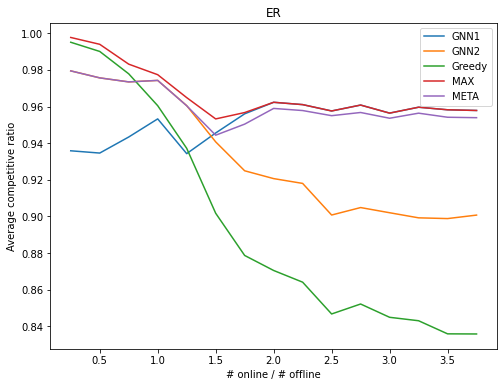

[[1.         1.         1.         1.         1.         1.
  1.         0.96207354 1.         0.96342048 1.         1.
  0.99801708 1.         1.         0.97469079 1.         1.
  0.92091613 0.98536371 1.         1.         0.9993348  0.97987589
  0.95659183 0.97784418 1.         1.         1.         1.
  1.         1.         0.90943565 0.999585   1.         0.99455197
  1.         1.         0.9913685  0.99453639 1.         0.99993831
  1.         0.95322166 1.         0.99853715 0.96539668 1.
  0.88534838 0.99077693]
 [1.         0.99823129 1.         1.         0.93884706 1.
  0.99465584 0.98014748 0.96414271 0.8854193  0.94764016 1.
  0.9834868  0.92591744 1.         0.97576836 1.         0.86053882
  0.92091613 0.98536371 1.         0.95881863 0.99899412 0.97987589
  0.92493005 0.83564573 0.9954526  0.95505986 0.95971438 0.97737077
  0.99849668 0.98336045 0.89059647 0.99917    0.94695111 0.94428514
  0.99944423 1.         0.9913685  0.97736598 1.         0.99993831
  1.       

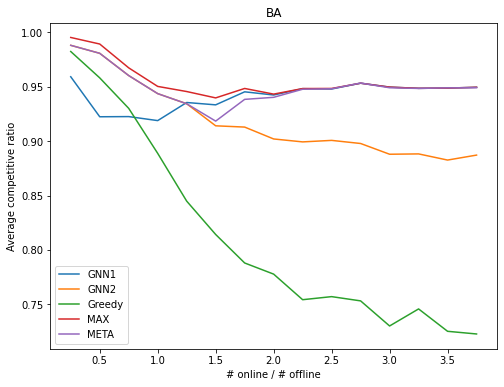

[[0.99573337 1.         1.         0.99618045 0.98613739 1.
  0.97779119 0.9796997  0.98028365 0.99544568 0.95782402 0.9661535
  1.         0.99156292 0.99892545 0.98761171 0.96990984 0.89428893
  0.95339632 0.99544815 0.98712352 1.         1.         0.99276392
  0.98156727 0.99619175 0.98188447 0.97654713 0.98161796 0.99335375
  0.99815307 0.9887576  1.         0.99451719 1.         1.
  0.97414533 0.99666934 1.         0.99834337 0.98563542 0.99970824
  0.97472722 0.9157106  1.         0.94296965 0.9911298  0.99489438
  0.99728468 0.99377998]
 [0.96503337 0.93539176 0.99699895 0.9771574  0.91690044 0.99364826
  0.7176674  0.96720793 0.76287692 0.99671405 0.95995622 0.96236352
  0.98790456 0.91746836 0.96770803 0.94474628 0.97553804 0.9005061
  0.95019669 0.84612741 0.95498639 0.86537629 0.90735139 0.99538179
  0.98274401 0.97229404 0.73069273 0.76888281 0.9883719  0.99600074
  0.99815307 0.940646   0.81739522 0.9719091  0.95755127 0.80069448
  0.78107514 0.98692654 1.         0.9999

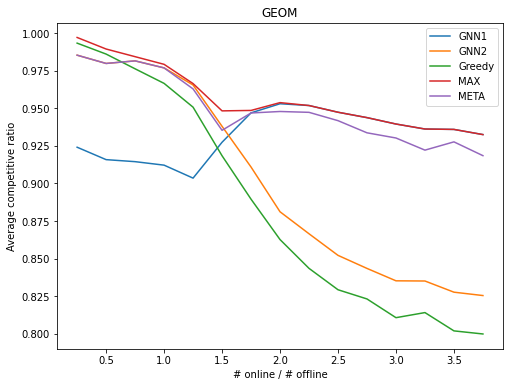

In [114]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for graph_type, comp_ratios in data.items():
    greedy_avg_ratios = []
    meta_avg_ratios = []
    gnn1_avg_ratios = []
    gnn2_avg_ratios = []
    max_avg_ratios = []

    for trial_ratios in comp_ratios:
        meta_avg_ratios.append(np.array(trial_ratios[0]).mean())
        gnn1_avg_ratios.append(np.array(trial_ratios[1]).mean())
        gnn2_avg_ratios.append(np.array(trial_ratios[2]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[3]).mean())
        max_avg_ratios.append(np.array(np.max(trial_ratios[1:, :], axis=0)).mean())
        print(trial_ratios)

    print(graph_type)
    fig = plt.figure(figsize=(8,6))
    plt.title(graph_type)
    plt.plot(ratios, gnn1_avg_ratios, label='GNN1')
    plt.plot(ratios, gnn2_avg_ratios, label='GNN2')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, max_avg_ratios, label='MAX')
    plt.plot(ratios, meta_avg_ratios, label='META')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.show()


In [ ]:
comp = np.vstack([gnn1_learned_ratios, gnn2_learned_ratios, greedy_ratios]).T
comp[:10]

In [ ]:
print(np.max(comp[:2, :], axis=1).mean())
print(comp.mean(axis=0))

In [ ]:
index1 = np.argmax(comp[:, 0] - comp[:, 1])
index2 = np.argmax(comp[:, 1] - comp[:, 0])

In [ ]:
tc._featurize(instances[index1])

In [ ]:
tc._featurize(instances[index2])

In [ ]:
GNN2_features = []
GNN1_features = []
for i, boolean in enumerate(comp[:, 1] > comp[:, 0]):
    if boolean:
        GNN2_features.append(tc._featurize(instances[i]))
    else:
        GNN1_features.append(tc._featurize(instances[i]))

out1 = np.vstack(GNN1_features)
out2 = np.vstack(GNN2_features)


In [ ]:
out1.mean(axis=0)

In [ ]:
out2.mean(axis=0)